In [1]:
from math import pi
import matplotlib.pyplot as plt
# from pennylane import numpy as np
import pennylane as qml
from pennylane.optimize import AdamOptimizer
import datetime
now=datetime.datetime.now

In [2]:
num_qubits=2
dev=qml.device('default.qubit', wires=num_qubits)

# define my own embedding layer
# def myembedding(x,wires):
#     # qml.RY(np.arcsin(x), wires=wires[0])
#     # qml.RY(2*pi*x, wires=wires[1])

def myembedding(x,wires):
    qml.RY(x, wires=wires[1])

def Ham():
    obs=[]
    for j in range(num_qubits):
        obs.append(qml.PauliX(j))
        for k in range(j):
            obs.append(qml.PauliZ(j)@qml.PauliZ(k))
    coeffs=np.random.uniform(-1,1,len(obs))*10
    qml.Hamiltonian(coeffs, obs)

# define ansastz layer
def layer(theta):
    
    # Apply Hamiltonian matrix
    Ham()
    
    # Apply H gate
    qml.Hadamard(0)
    
    # rotations on qubits
    qml.RY(theta[0],wires=0)
    qml.RY(theta[1],wires=1)
    
    # CNOT
    qml.CNOT(wires=[0, 1])

@qml.qnode(dev)
def quantum_net(theta,x):
    
    # encode data
    myembedding(x,wires=range(num_qubits))
    
    # parameterized circuit layers
    for v in theta: # (for lool along with the first dimension)
        # Ham()
        layer(v)
    
    qml.Hadamard(0)
    
    return qml.expval(qml.PauliZ(0))

In [3]:

# print(theta.shape)
# # print(theta)
# print(qml.draw(quantum_net)(theta,0))



# add the classical layer
def classical_quantum_net(theta,w,x):
    r=quantum_net(theta,x)
    return w[0]+w[1]*r+w[2]*r**2
    # return w[0]+w[1]*r



In [4]:
import numpy as np
from scipy.optimize import minimize


def f(theta,w, t):
    r=quantum_net(theta,t)
    return w[0]+w[1]*r+w[2]*r**2


# Differential equation parameters
ws = 376.9911
# Boundary condition 
coefii = 10

# del_0 = 0  #del
# omega_0 = 0     #w
# del_0_v = -1/coefii
# omega_0_v = 383.9911/coefii
del_0_v = 0.21610363365782925
omega_0_v = 37.621933647607996

K1 = 5/coefii
K2 = 10/coefii
K3 = 1.7/coefii
ws = ws/coefii
def DE(f,f_prime,f_double_prime,t):
    delta = f
    delta_prime = f_prime
    omega = delta_prime+ws
    omega_prime = f_double_prime
    return (delta_prime+ws-omega)+omega_prime-K1+K2*np.sin(coefii*delta)+K3*(-ws+omega)*coefii
    

n_grid = 20
range_min = 1.5
range_max = 2
t_data = np.linspace(range_min, range_max, n_grid)
dt = t_data[1]-t_data[0]
# print(dt)
print(t_data)
# del_target_values = [-0.1, -0.08568864375010266, -0.07135199292327042, -0.05703216366155178, -0.04277533332758968, -0.028630566403092566, -0.014648393492369936, -0.0008786099410683636, 0.012629993562057113, 0.025830965225360485, 0.03868190003112095, 0.05114514907683676, 0.06318818053413534, 0.07478349631699908, 0.08590929364185632, 0.09655108128205876, 0.10669910851327256, 0.11634802541217151, 0.12549688285643618, 0.13414913252475494, 0.1423124546002818, 0.14999727816970396, 0.1572170147933966, 0.16398646160587024, 0.17032150117763253, 0.17623910151518826, 0.18175731606103976, 0.18689528211221512, 0.19167252338163385, 0.1961073022258, 0.2002172705183872, 0.2040196495808423, 0.20753123018238517, 0.21076837254000894, 0.21374700631847987, 0.2164826306303374, 0.21899031403589397, 0.22128469454323552, 0.2233792634241711, 0.22528520015009165, 0.22701309424038968, 0.22857304585789437, 0.22997466468065175, 0.2312270699019247, 0.23233889023019288, 0.23331826388915283, 0.23417283861771784, 0.2349097716700181, 0.2355355471757422, 0.23605508170803655]
# omega_target_values = [38.39911, 38.40131255162024, 38.401559501400065, 38.399627615014815, 38.39535272010845, 38.38863569037213, 38.37944575798523, 38.36781828175373, 38.35385457506316, 38.33771250498817, 38.31960064799821, 38.29975795463622, 38.27844654658136, 38.25594953663366, 38.232548774138536, 38.20852344187769, 38.184133101993716, 38.15961422638989, 38.135180196730154, 38.11102130443908, 38.0873045267779, 38.0641648590319, 38.04170495996719, 38.020008128295665, 37.999139183467754, 37.979144465672405, 37.96005183583712, 37.94187079269068, 37.92460193204962, 37.90823330461032, 37.892744190413474, 37.87811073974539, 37.864305973137945, 37.851299781368624, 37.83905892546051, 37.82754703668229, 37.816724616548235, 37.80654903681822, 37.7969789305147, 37.78797953688034, 37.779515522995986, 37.77155243468513, 37.76405670589686, 37.75699565870589, 37.75033750331248, 37.744051338042496, 37.73810714934741, 37.73247581180426, 37.72712975291509, 37.7220465421391]


def callbackF(parameters):
    # global current_loss

    print("Current loss:", cost(parameters)) 


def cost(params):
    global theta
    global w
    # Reshape the flattened theta back to its original shape
    theta_shape = theta.shape
    w_shape = w.shape
    w, theta_flat = params[:3], params[3:]
    theta = theta_flat.reshape(theta_shape)


    u = np.zeros(n_grid + 2)
    u[0] = f(theta,w, range_min - dt)
    u[1] = del_0_v
    for i in range(1, n_grid):
        u[i + 1] = f(theta,w, t_data[i])
    u[n_grid + 1]=f(theta,w, range_max + dt)
  
    u_prime = (u[2:] - u[:-2])/(2*dt)
    omega_0 = u_prime[0]+ws
    u_double_prime = (u_prime[2:] - u_prime[:-2])/(2*dt)
    loss_i = np.sum((DE(f=u[2:-2],f_prime=u_prime[1:-1],f_double_prime=u_double_prime,t=t_data[1:-1]))**2)
    
    eta = 5
    # del0_pred = f(a, b, c, d, 0)
    # omega0_pred = f_prime(a, b, c, d, 0) + ws
    # loss_b = eta * (del_0_v - del0_pred) ** 2 * len(t_data)
    loss_b = 0
    loss_b += eta * (omega_0_v - omega_0) ** 2 * len(t_data)

    # loss = 10*loss_i+8*loss_b
    loss = loss_i+loss_b
    # loss = loss_i
    # print("Current loss:", loss) 
    return loss



[1.5        1.52631579 1.55263158 1.57894737 1.60526316 1.63157895
 1.65789474 1.68421053 1.71052632 1.73684211 1.76315789 1.78947368
 1.81578947 1.84210526 1.86842105 1.89473684 1.92105263 1.94736842
 1.97368421 2.        ]


In [5]:

# opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

# num_layers=4
# theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits),requires_grad=True)
# w=np.zeros(3,requires_grad=True)


# epochs=100
# for e in range(1,epochs+1):
    
#     (theta,w,_),_cost=opt.step_and_cost(cost,theta,w,t_data)
#     if e==1 or e%10==0:
#         print(f'Epoch: {e} | Cost: {_cost} | w: {w} | theta: {theta}')

In [6]:
num_layers=4

theta = np.random.uniform(0, 2 * np.pi, size=(num_layers, num_qubits))
w = np.zeros(3)

initial_params = np.concatenate([w, theta.flatten()])  # Flatten theta to a 1D array

result = minimize(cost, initial_params, callback=callbackF, method='BFGS', options={'gtol': 1E-2})
# Extract the optimized parameters
w, theta_flat = result.x[:3], result.x[3:]
theta = theta_flat.reshape(theta.shape)

Current loss: 12.57412707825174
Current loss: 3.9365046776733004
Current loss: 2.393716932855005
Current loss: 2.0317523252128304
Current loss: 2.012799749174098
Current loss: 1.7481400508038962
Current loss: 1.232683058089328
Current loss: 0.9438415504384663
Current loss: 0.47953280080399985
Current loss: 0.18886245810725616
Current loss: 0.14713748446261748
Current loss: 0.11011000792985642
Current loss: 0.07211979097357445
Current loss: 0.05910705472348024
Current loss: 0.034561249202541056
Current loss: 0.019896419984068207
Current loss: 0.013652651438629634
Current loss: 0.01035003637763288
Current loss: 0.006372313276333851
Current loss: 0.004724775728849116
Current loss: 0.004358752260917528
Current loss: 0.004291271907312123
Current loss: 0.00427492316949279
Current loss: 0.004263835382839467
Current loss: 0.004243785275047253
Current loss: 0.004208165471382642
Current loss: 0.004151725746014273
Current loss: 0.004072307474137283
Current loss: 0.003949291872879454
Current loss:

In [7]:
print(w)
print(theta)

[-0.09627888 -0.70076244 -0.37088045]
[[ 3.05146902  2.08489313]
 [ 1.3608461   5.03363159]
 [ 5.67219956  3.22538482]
 [-0.96013526  2.08086098]]


In [8]:
# num_layers=4
# # theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits),requires_grad=True)
# theta=np.random.uniform(0,2*pi,size=(num_layers,num_qubits))
# # w=np.zeros(3,requires_grad=True)
# w=np.zeros(3)


# initial_params = [w,theta]
# # initial_params = [4, 4, 4,4]
# # initial_params = [10, 20, 8,70]
# # initial_params = [1.5703050481447, 6.664583545312459, 8.490607793546264,-1.0593486531798044]
# # initial_params = [0.17749722218115743, -0.6981313539613472, 0.8622182932697816,-0.1070692270857497]

# # result = minimize(loss, initial_params, method='Nelder-Mead')
# result = minimize(cost, initial_params, callback=callbackF, method='BFGS', options={'gtol': 1E-2})

# theta,w = result.x

In [9]:
del_target_values =[0.22379790761838508, 0.22198252902542048, 0.22004639707105003, 0.21798620009721814, 0.2157987640012428, 0.21348105223581534, 0.2110301658090007, 0.2084433432842374, 0.20571796078033708, 0.20285153197148534, 0.19984170808724083, 0.19668627791253632, 0.19338316778767758, 0.1899304460524845, 0.18632649742283225, 0.182570322512733, 0.17866169923652797, 0.17460120922682132, 0.17039023783448032, 0.16603097412863455]
omega_target_values = [37.632367819714716, 37.627795842632864, 37.623131802494456, 37.61836806507993, 37.613499054928454, 37.608521255337955, 37.603433208365054, 37.59823551482514, 37.59293083429232, 37.58752388509944, 37.582021444338075, 37.57643234785854, 37.57076749026989, 37.56504002154816, 37.5592696233155, 37.553479037414036, 37.547693585856685, 37.54194222608139, 37.5362575509511, 37.53067578875376]



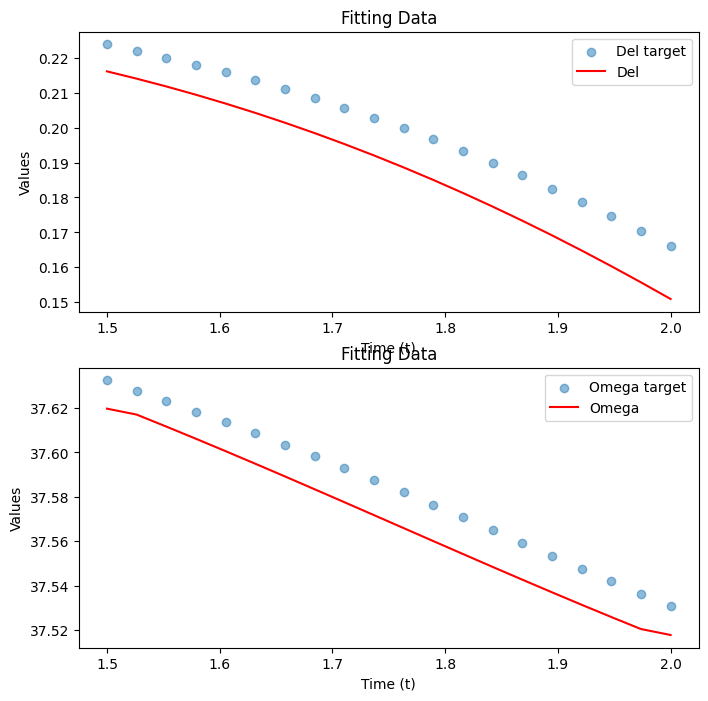

20
20
0.1509518170189046
37.517842735656394
[0.21609916 0.21400887 0.21177807 0.20940403 0.2068843  0.20421674
 0.2013995  0.19843109 0.19531033 0.19203639 0.1886088  0.18502744
 0.18129258 0.17740484 0.17336525 0.16917519 0.16483645 0.1603512
 0.15572201 0.15095182]
[37.61967885 37.61700926 37.61161809 37.60612841 37.60055144 37.59489884
 37.58918274 37.5834157  37.57761064 37.57178087 37.56593998 37.56010187
 37.55428068 37.54849074 37.54274658 37.53706283 37.53145424 37.52593558
 37.52052166 37.51784274]


In [10]:
import matplotlib.pyplot as plt

# Plot the target values and the fitted curve
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.scatter(t_data, del_target_values, label='Del target', alpha=0.5)
delta_pred = f(theta,w,t_data)
plt.plot(t_data, delta_pred, 'r', label='Del')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')


# Plot the target values and the fitted curve
# plt.figure(figsize=(8, 6))
plt.subplot(2, 1, 2)
plt.scatter(t_data, omega_target_values, label='Omega target', alpha=0.5)

del_prime = np.gradient(delta_pred, t_data)
omega_pred = del_prime+ws

plt.plot(t_data, omega_pred, 'r', label='Omega')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.legend()
plt.title('Fitting Data')
plt.show()

# plt.show()
print(len(delta_pred))
print(len(omega_pred))
print(delta_pred[-1])
print(omega_pred[-1])

print(delta_pred)
print(omega_pred)